## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
df = pd.read_csv('Country-data.csv')

In [4]:
# Check the shape
print(df.shape)

(167, 10)


In [5]:
# Check datatypes & counts
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [6]:
# Get descriptive statistics
print(df.describe())

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [7]:
# Identify any missing data
print(df.isnull().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [8]:
# Drop any non-numeric features (columns)
df_numeric = df.drop(['country'], axis=1)

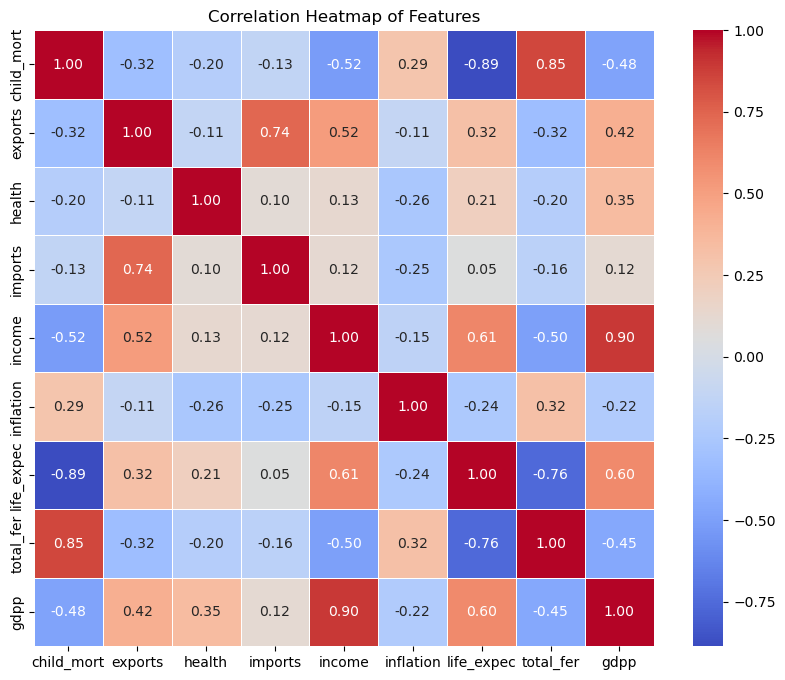

In [9]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
# Create a correlation matrix for the numerical attributes
correlation_matrix = df_numeric.corr()

# Plot the correlation heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()

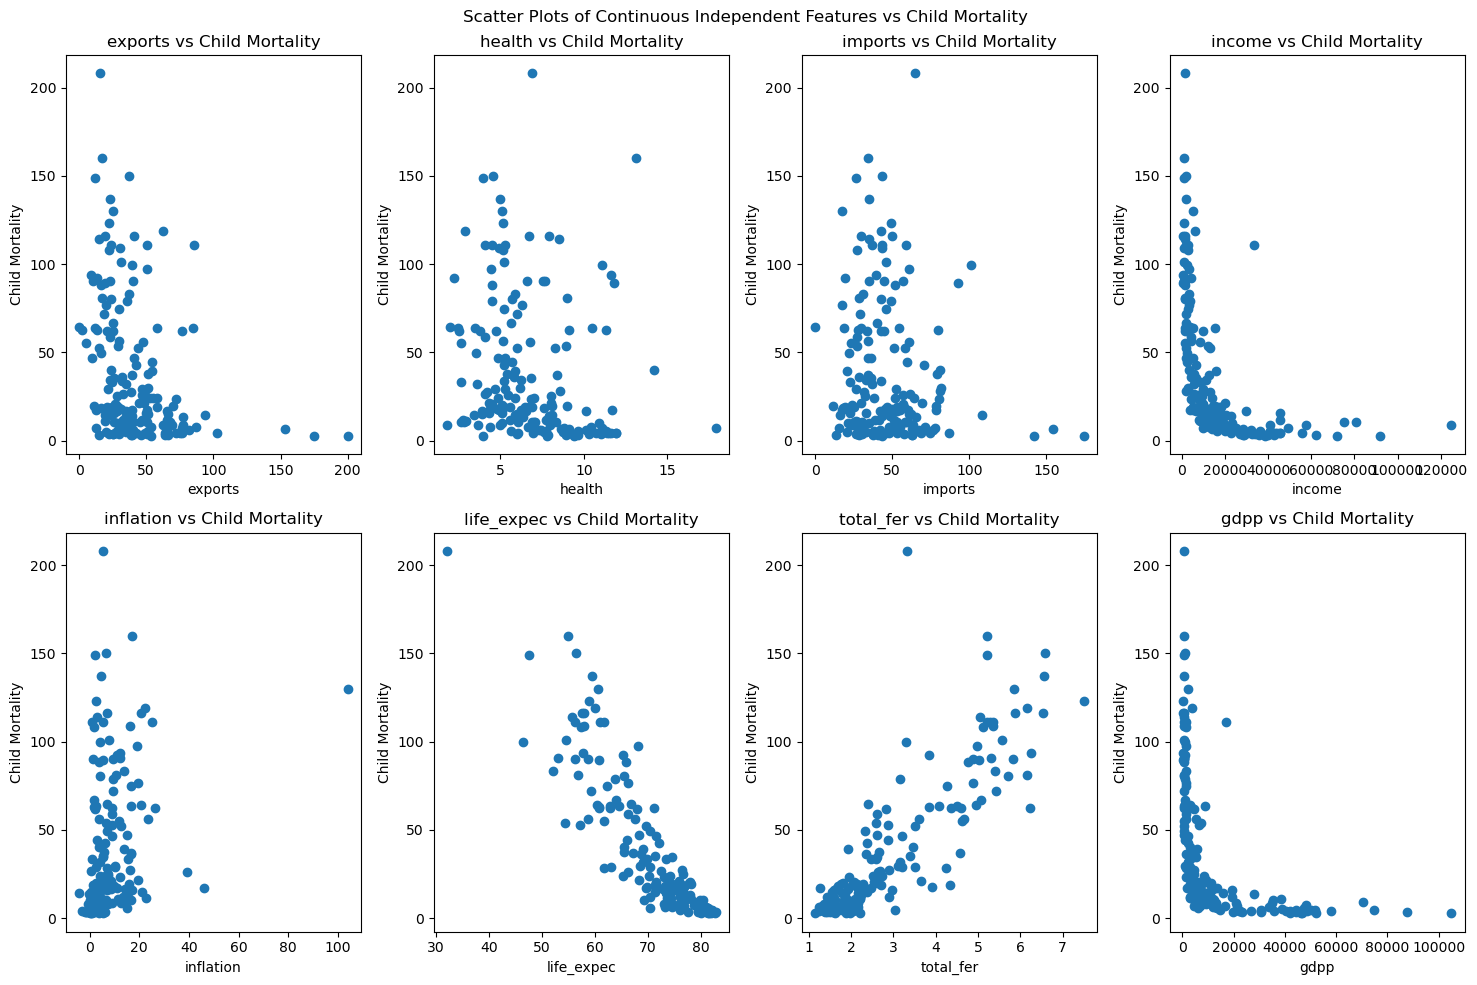

In [10]:
# Explore the continuous independent features against child_mort using scatter plots.
continuous_features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
fig.suptitle('Scatter Plots of Continuous Independent Features vs Child Mortality')

for i, feature in enumerate(continuous_features):
    row, col = i // 4, i % 4
    axes[row, col].scatter(df[feature], df['child_mort'])
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Child Mortality')
    axes[row, col].set_title(f'{feature} vs Child Mortality')

plt.tight_layout()
plt.show()

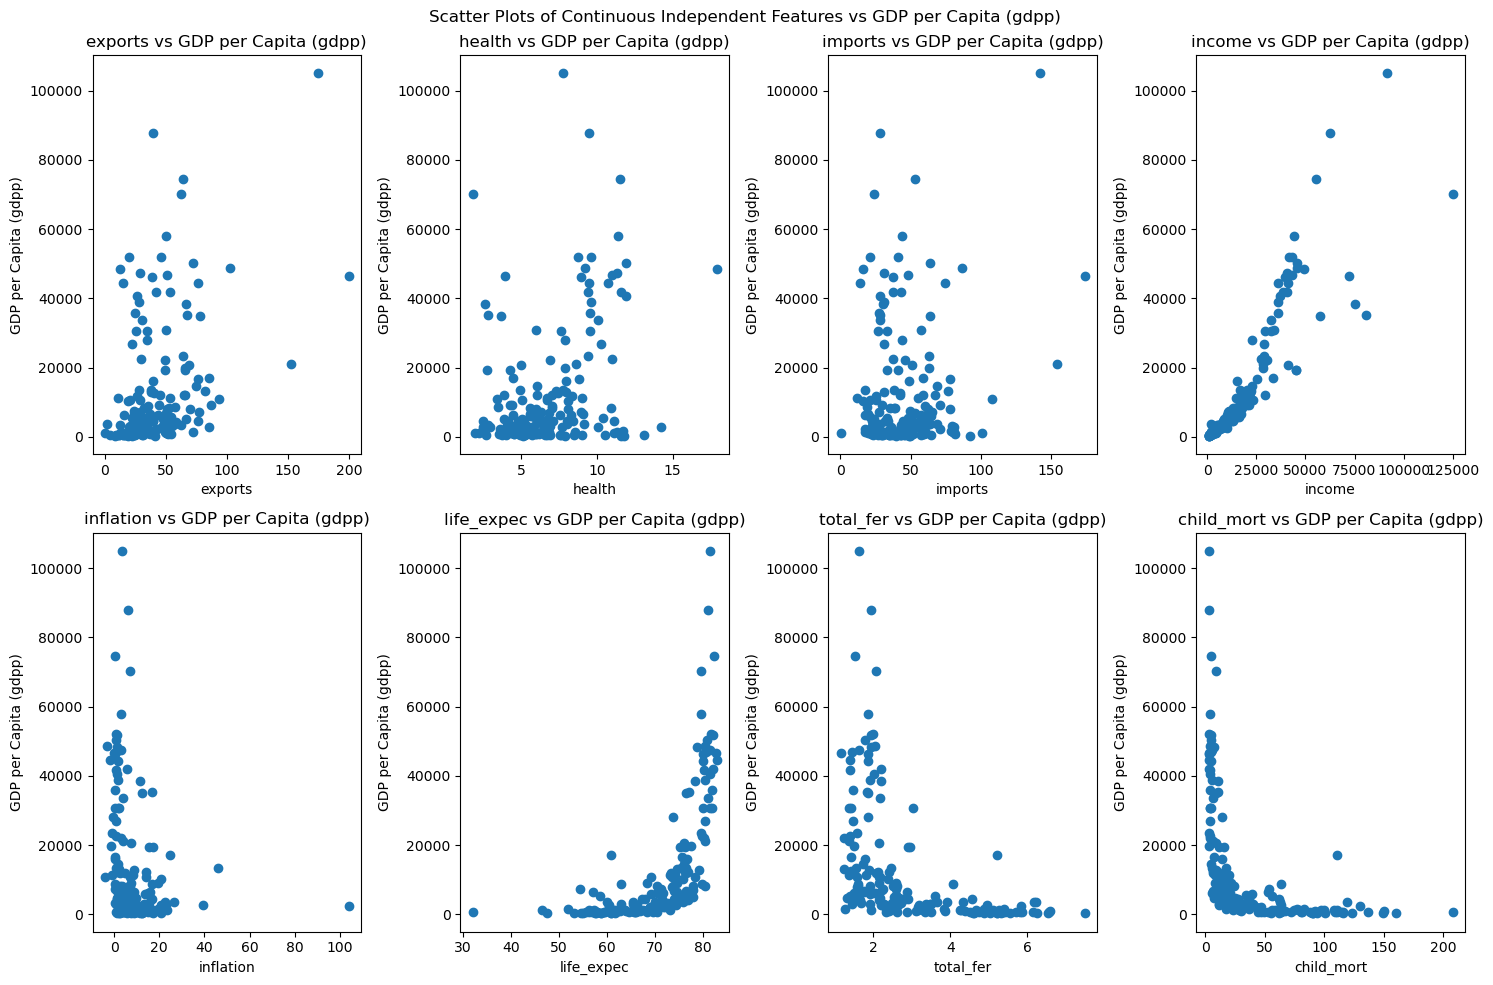

In [11]:
# Explore the continuous independent features against gdpp using scatter plots.
continuous_features = ['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'child_mort']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
fig.suptitle('Scatter Plots of Continuous Independent Features vs GDP per Capita (gdpp)')

for i, feature in enumerate(continuous_features):
    row, col = i // 4, i % 4
    axes[row, col].scatter(df[feature], df['gdpp'])
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('GDP per Capita (gdpp)')
    axes[row, col].set_title(f'{feature} vs GDP per Capita (gdpp)')

plt.tight_layout()
plt.show()

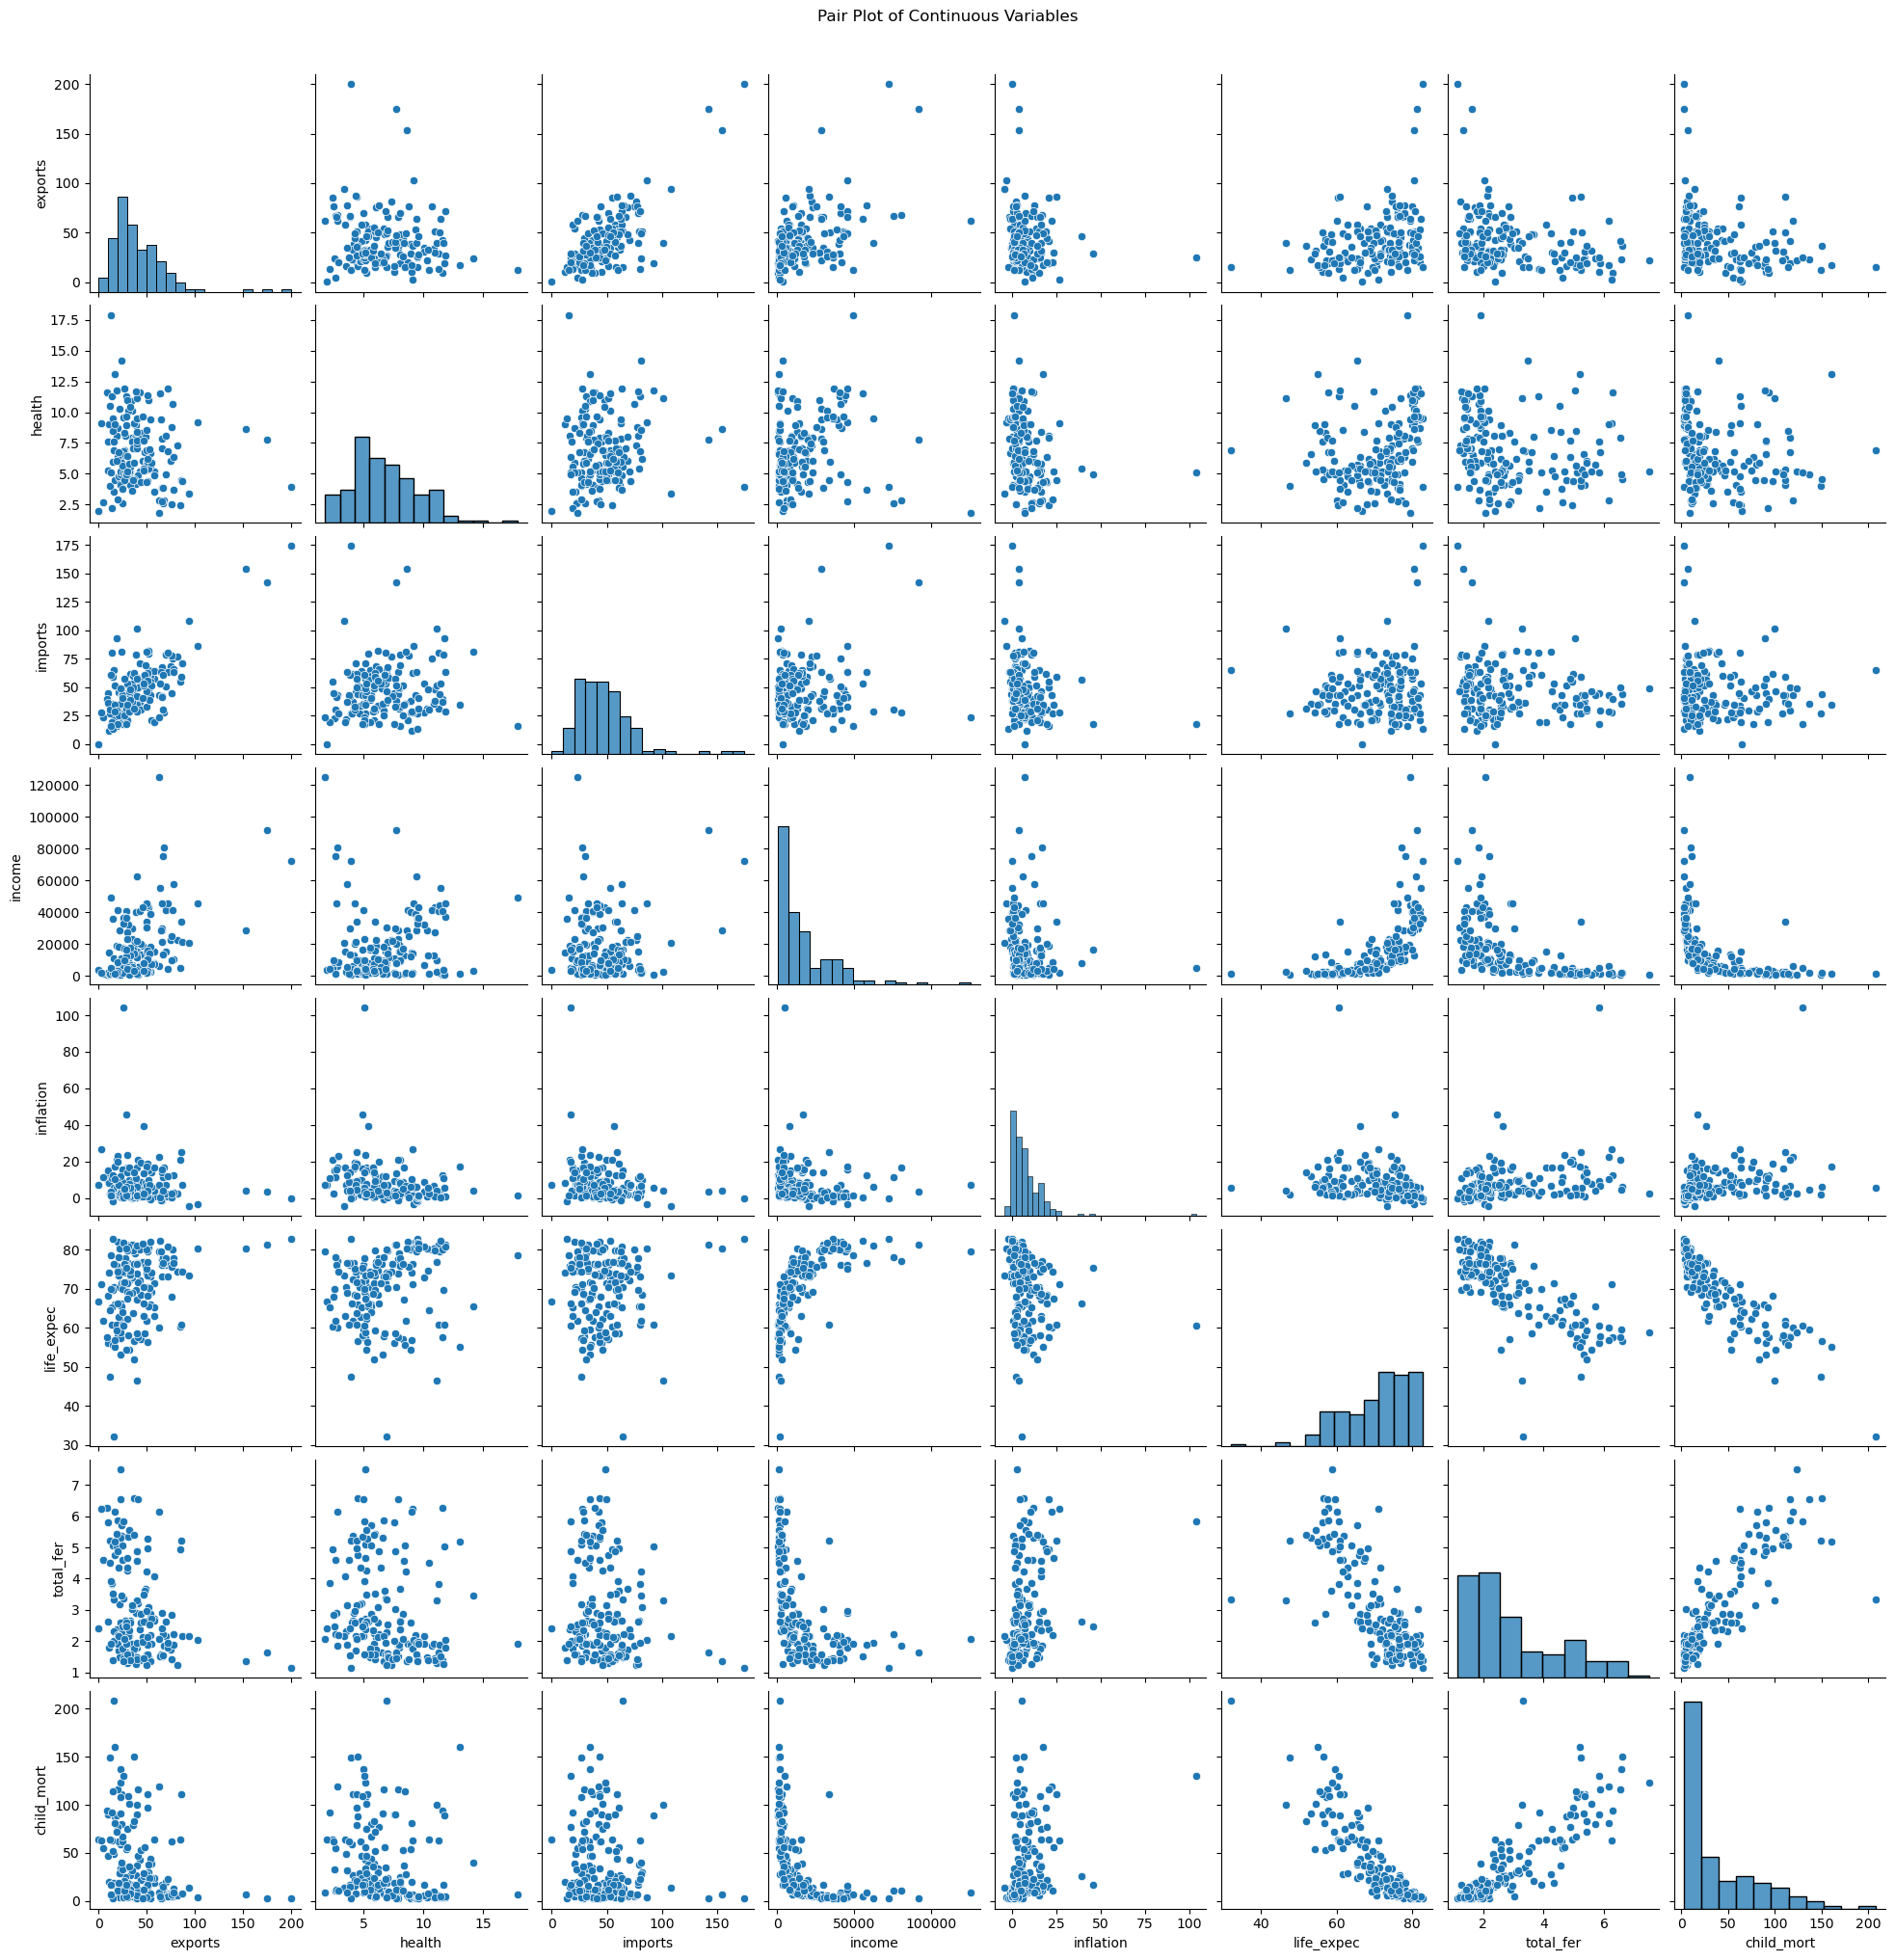

In [12]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(df[continuous_features])
plt.suptitle('Pair Plot of Continuous Variables', y=1.02)
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [13]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the dataset
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)

# df_scaled.head()
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

In [14]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

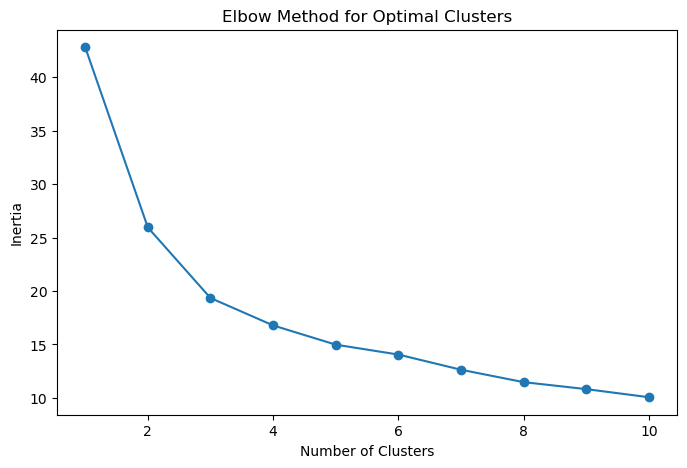

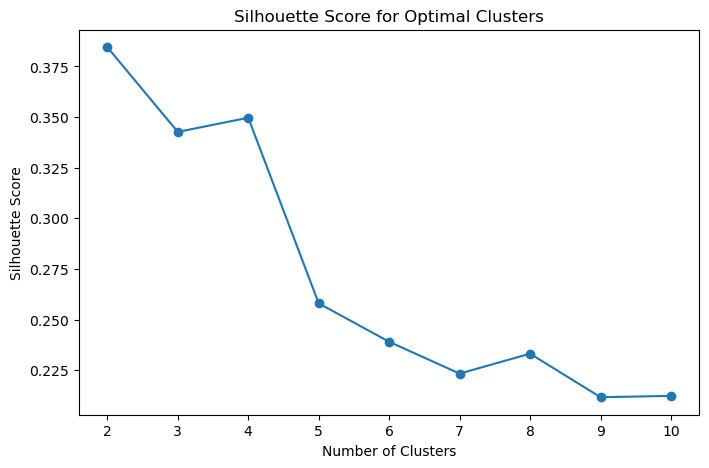

In [15]:
# Step 4: Find the optimal number of clusters using elbow and silhouette score methods
inertia = []
silhouette_scores = []
max_clusters = 10

for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters+1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Plot the silhouette score method
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

Based on the elbow and silhouette score method choose a value for K.

In the elbow method plot, we observe that there is a negative linear relationship between the inertia and the number of clusters as the inertia (within-cluster sum of squares) decreases as the number of clusters increases. The point where the inertia starts to level off and form a so-called elbow is considered the optimal number of clusters. In this case, there is no clear elbow, but we can see a slight change in slope around 3 or 4 clusters. So, we may consider either 3 or 4 clusters as the optimal choice.

The silhouette score measures how similar an object is to its own cluster compared to others. Higher silhouette scores indicate better-defined clusters. In the silhouette score plot, we can see that the scores are relatively higher for 3 clusters, indicating that this could be the optimal number of clusters.

## Fitting a K-Means Model with the selected K value

In [16]:
# Remember to set the random_state to rseed

In [17]:
# Step 5: Fit the scaled dataset to the optimal number of clusters and report the silhouette score
optimal_clusters = 3  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=rseed)
df['cluster'] = kmeans.fit_predict(df_scaled)

silhouette_avg = silhouette_score(df_scaled, df['cluster'])
print("Silhouette Score for {} Clusters: {:.3f}".format(optimal_clusters, silhouette_avg))

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score for 3 Clusters: 0.343


In [18]:
# Assign cluster labels to each data point
df['Cluster'] = kmeans.labels_

# Count the number of records in each cluster
cluster_counts = df['Cluster'].value_counts()
print("Number of records in each cluster:")
print(cluster_counts)

Number of records in each cluster:
1    87
0    46
2    34
Name: Cluster, dtype: int64


In [19]:
# Check model performance with the silhouette coefficient

## Predictions

In [20]:
# Add the predicted cluster label column to the original dataframe
# Print the cluster labels for each country
print(df[['country', 'Cluster']])

                 country  Cluster
0            Afghanistan        0
1                Albania        1
2                Algeria        1
3                 Angola        0
4    Antigua and Barbuda        1
..                   ...      ...
162              Vanuatu        1
163            Venezuela        1
164              Vietnam        1
165                Yemen        0
166               Zambia        0

[167 rows x 2 columns]


## Visualisation of clusters

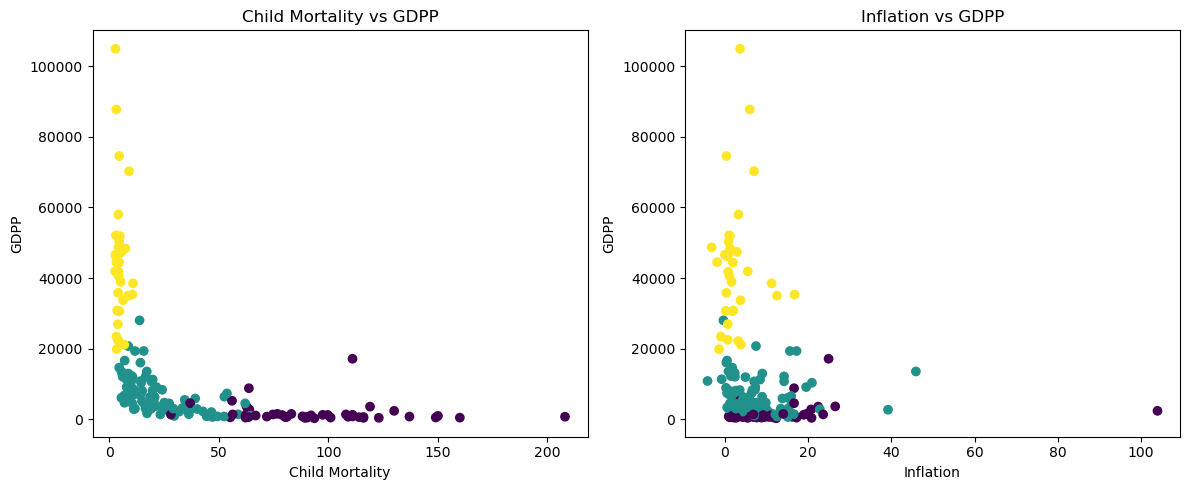

In [21]:
# Step 6: Visualize the clusters for Child Mortality vs GDPP and Inflation vs GDPP
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df['child_mort'], df['gdpp'], c=df['cluster'], cmap='viridis')
plt.xlabel('Child Mortality')
plt.ylabel('GDPP')
plt.title('Child Mortality vs GDPP')
plt.subplot(1, 2, 2)
plt.scatter(df['inflation'], df['gdpp'], c=df['cluster'], cmap='viridis')
plt.xlabel('Inflation')
plt.ylabel('GDPP')
plt.title('Inflation vs GDPP')
plt.tight_layout()
plt.show()

In [23]:
# Analyze the characteristics of each cluster
cluster_characteristics = df.groupby('cluster').mean()

# Assign labels to the clusters based on characteristics
label_map = {
    0: 'Low Income',
    1: 'Low-Middle Income',
    2: 'Upper-Middle/High Income'  # Depending on the characteristics, this cluster could be either upper-middle or high income
}

df['cluster_label'] = df['cluster'].map(label_map)

# Display the cluster labels and characteristics
print(df[['country', 'cluster_label']])

                 country      cluster_label
0            Afghanistan         Low Income
1                Albania  Low-Middle Income
2                Algeria  Low-Middle Income
3                 Angola         Low Income
4    Antigua and Barbuda  Low-Middle Income
..                   ...                ...
162              Vanuatu  Low-Middle Income
163            Venezuela  Low-Middle Income
164              Vietnam  Low-Middle Income
165                Yemen         Low Income
166               Zambia         Low Income

[167 rows x 2 columns]


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


In [24]:
# Analyze and label the groups based on child mortality, GDPP, and inflation
df['label'] = np.nan

# Group 1: Least Developed (Highest Child Mortality, Lowest GDPP, High Inflation)
group1_idx = df[(df['cluster'] == 0)].index
df.loc[group1_idx, 'label'] = 'Least Developed'

# Group 2: Developing (Moderate Child Mortality, Moderate GDPP, Moderate Inflation)
group2_idx = df[(df['cluster'] == 1)].index
df.loc[group2_idx, 'label'] = 'Developing'

# Group 3: Developed (Lowest Child Mortality, Highest GDPP, Low Inflation)
group3_idx = df[(df['cluster'] == 2)].index
df.loc[group3_idx, 'label'] = 'Developed'

# Display the DataFrame with cluster labels
print(df[['country', 'label']])

                 country            label
0            Afghanistan  Least Developed
1                Albania       Developing
2                Algeria       Developing
3                 Angola  Least Developed
4    Antigua and Barbuda       Developing
..                   ...              ...
162              Vanuatu       Developing
163            Venezuela       Developing
164              Vietnam       Developing
165                Yemen  Least Developed
166               Zambia  Least Developed

[167 rows x 2 columns]


**Answer here:** Least Developed: This group represents countries with the highest child mortality rates, lowest GDP per capita, and high inflation. These countries are challenged in healthcare and economic development, and stability.

Developing: This group represents countries with moderate child mortality rates, moderate GDP per capita, and moderate inflation. These countries are still developing and are emerging markets working to improve their healthcare and economic conditions.

Developed: This group represents countries with the lowest child mortality rates, highest GDP per capita, and low inflation. These countries have achieved significant progress in terms of healthcare, economic advancement, and stability.